In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pylab as pl
import numpy as np
import xarray as xr
import sys
sys.path.append('../')
import spym
# Using the old loader
from spym.io import rhksm4
# import data structure
from rhkpy import rhkpy as sm4

In [4]:
# 4x4 dIdV map
filename = 'hopg_300k_2020_08_11_16_04_06_999.sm4'
didvmap = rhksm4.load(filename)
didvmap2 = spym.load(filename)
# didvmap_new = sm4.stmdata(filename)

In [3]:
# import the ASCII loader
sys.path.append('C:/Users/zrbyt/OneDrive - energia.mta.hu/Documents/GitHub/RHK-STM-processing/')
from didvmap_spec import spectra_map, spectrum

In [6]:
mapascii = spectra_map()
mapascii.read_ascii(filename[:-4])
mapascii.description()

stabilization bias: 400.0 mV, 
stabilization current: 500.0 pA 
number of spectra: 32 
datapoints in spectra: 241 
filename: hopg_300k_2020_08_11_16_04_06_999


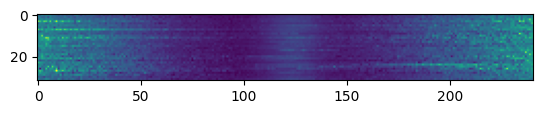

In [6]:
pl.imshow(didvmap[6].data.T)

In [5]:
didvmap.__dict__

{'_file': <_io.BufferedReader name='hopg_300k_2020_08_11_16_04_06_999.sm4'>,
 '_header': <spym.io.rhksm4._sm4.RHKFileHeader at 0x267c7001c00>,
 '_page_index_header': <spym.io.rhksm4._sm4.RHKPageIndexHeader at 0x267c7001d20>,
 '_pages': [<spym.io.rhksm4._sm4.RHKPage at 0x267dd5a7520>,
  <spym.io.rhksm4._sm4.RHKPage at 0x267dd5a7fa0>]}

In [6]:
len(didvmap._pages)

8

In [7]:
didvmap._pages

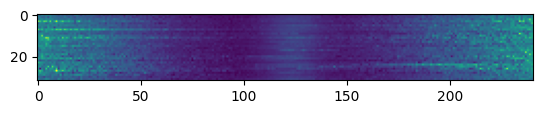

In [8]:
pl.imshow(didvmap2.LIA_Current.data.T)

# Rearrange the spectroscopy data into an $N \times N$ array

## testing the reshape method
I'm assuming in this case that there we measure 2 spectra in each pixel, with alternate scan direction turned on. So 4 spectra in all in one pixel of a 4x4 map.

In [6]:
alternate = True
repetition = 2
numberofspectra = (alternate + 1)*repetition
print(numberofspectra)

4


In [7]:
a = pl.array(range(64))

In [8]:
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

Separate the array into batches as large as the number of spectra at one physical `X, Y` position. 

In [9]:
aa = pl.reshape(a, (-1, numberofspectra), order='C')
print(aa)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]
 [48 49 50 51]
 [52 53 54 55]
 [56 57 58 59]
 [60 61 62 63]]


In [10]:
aa.shape

(16, 4)

every other spectrum in the above, is a forward and backward scan of the bias

In [11]:
aa_fw = aa[:, 0::2]
aa_bw = aa[:, 1::2]
print(aa_fw.T)
print(aa_bw.T)

[[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60]
 [ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62]]
[[ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61]
 [ 3  7 11 15 19 23 27 31 35 39 43 47 51 55 59 63]]


reshape the forward and backward spectra into a $mapsize \times mapsize$ array

In [115]:
aa_fw.shape

(16, 2)

In [116]:
aaa_fw = pl.reshape(aa_fw, (4, 4, aa_fw.shape[1]), order='C')

In [117]:
aaa_fw[:, :, 0]

array([[ 0,  4,  8, 12],
       [16, 20, 24, 28],
       [32, 36, 40, 44],
       [48, 52, 56, 60]])

In [118]:
aaa_fw[:, :, 1]

array([[ 2,  6, 10, 14],
       [18, 22, 26, 30],
       [34, 38, 42, 46],
       [50, 54, 58, 62]])

take the mean of all the spectra in a fw and bw directions

In [119]:
pl.mean(aaa_fw, axis=2)

array([[ 1.,  5.,  9., 13.],
       [17., 21., 25., 29.],
       [33., 37., 41., 45.],
       [49., 53., 57., 61.]])

## Rearranging the spectra in a specific case

In [112]:
spec = didvmap2.LIA_Current.data

In [113]:
# number of spectra at the same X, Y coordinate
repetition = 1
# is alternate scan direction enabled?
alternate = True
# in this case the number of spectra in each point is multiplied by 2

In [114]:
print(True + 1)
print(False + 1)

2
1


number of spectra in one `X, Y` position

In [115]:
numberofspectra = (alternate + 1)*repetition
print(numberofspectra)

2


In [116]:
mapsize = int(pl.sqrt(spec.shape[1] / numberofspectra))
print(mapsize)

4


In [117]:
spec.shape

(241, 32)

collect all spectra measured in the same `X, Y` coordinate into an axis (last) of an array.

In [118]:
specc = pl.reshape(spec, (spec.shape[0], -1, numberofspectra), order='C')

In [119]:
specc.shape

(241, 16, 2)

Every other spectrum is a forward and backward scan in bias sweep.
Separate the forward and backward scans into differing arrays by slicing.

In [122]:
specc_fw = specc[:, :, 0::2]
specc_bw = specc[:, :, 1::2]

In [123]:
specc_fw.shape

(241, 16, 1)

reshape the forward and backward parts into a map

In [124]:
speccmap_fw = pl.reshape(specc_fw, (specc_fw.shape[0], mapsize, mapsize, specc_fw.shape[2]), order='C')

In [125]:
speccmap_fw.shape

(241, 4, 4, 1)

In [126]:
pl.flip(speccmap_fw, axis=1).shape

(241, 4, 4, 1)

The last axis (in this case with length of 1) contains the repeated scans in one particular pixel. If the `repetitions` variable is set to greater than 1, this will contains the repeated spectra within an `X, Y` pixel.

The array needs to be flipped along axis = 1 (the "x" axis in the topography image) to fit with the data read by the ASCII method

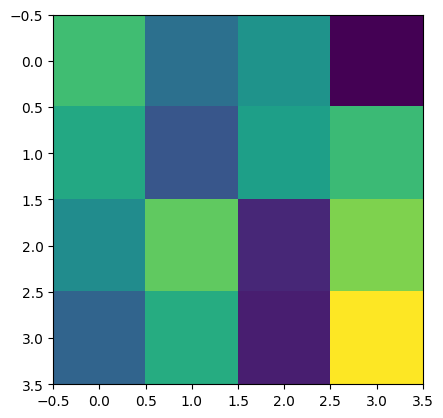

In [127]:
pl.imshow(pl.flip(speccmap_fw[120, :, :, 0], axis=1))

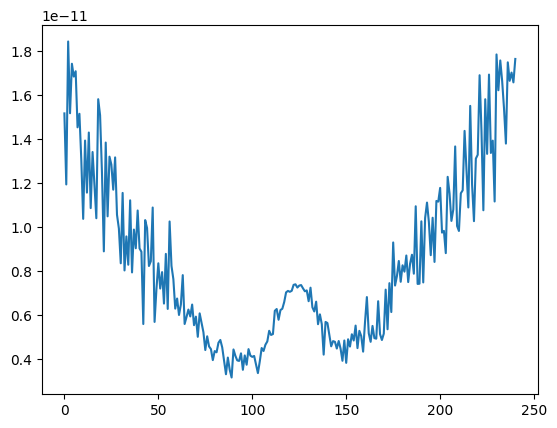

In [141]:
pl.plot(speccmap_fw[:, 0, 0, 0])

Compare to the ASCII loaded map of the forward scan

Text(0.5, 1.0, 'sm4 import')

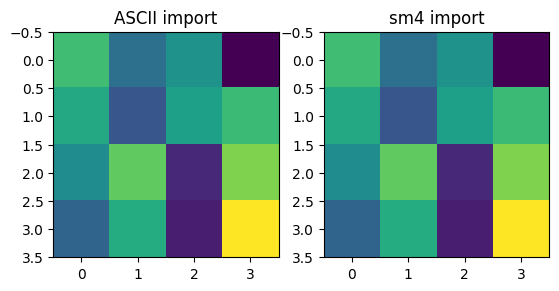

In [129]:
fig, (ax1, ax2) = pl.subplots(1, 2)

biasindex = 120

ax1.imshow(mapascii.map_fw[:, :, biasindex])
ax1.set_title('ASCII import')
ax2.imshow(pl.flip(speccmap_fw[biasindex, :, :, 0], axis=1))
ax2.set_title('sm4 import')

In [60]:
d = sm4.stmdata(filename)

In [225]:
d.lia_fw.shape

(241, 4, 4, 1)

Text(0.5, 1.0, 'backward sweep')

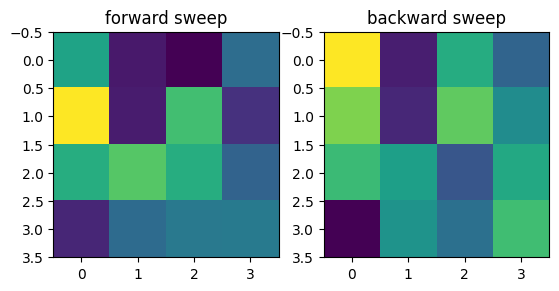

In [133]:
fig, (ax1, ax2) = pl.subplots(1, 2)

biasindex = 120

ax1.imshow(d.lia_bw[biasindex, :, :, 0])
ax1.set_title('forward sweep')
ax2.imshow(d.lia_fw[biasindex, :, :, 0])
ax2.set_title('backward sweep')

In [134]:
for item in d.__dict__:
    print(item)

filename
numberofspectra
spymdata
lia_fw
lia_bw


In [135]:
d.__dict__.keys()

dict_keys(['filename', 'numberofspectra', 'spymdata', 'lia_fw', 'lia_bw'])

In [136]:
d.print_info()

filename
numberofspectra
spymdata
lia_fw
lia_bw

spymdata:
	 LIA_Current_Backward
	 LIA_Current_Forward
	 Current_Backward
	 Current_Forward
	 Topography_Backward
	 Topography_Forward
	 LIA_Current
	 Current


# dI/dV xarray DataArray construction

In [230]:
d.lia_fw.shape

(241, 4, 4, 1)

Last axis will be the scan direction, forward or backward

In [138]:
lia_stacked = pl.stack((d.lia_fw, d.lia_bw), axis=-1)

In [139]:
lia_stacked.shape

(241, 4, 4, 1, 2)

In [140]:
d.spymdata.coords

Coordinates:
  * LIA_Current_Backward_x  (LIA_Current_Backward_x) float64 0.0 ... 9.961e-08
  * LIA_Current_Backward_y  (LIA_Current_Backward_y) float64 0.0 ... 9.961e-08
  * LIA_Current_Forward_x   (LIA_Current_Forward_x) float64 0.0 ... 9.961e-08
  * LIA_Current_Forward_y   (LIA_Current_Forward_y) float64 0.0 ... 9.961e-08
  * Current_Backward_x      (Current_Backward_x) float64 0.0 ... 9.961e-08
  * Current_Backward_y      (Current_Backward_y) float64 0.0 ... 9.961e-08
  * Current_Forward_x       (Current_Forward_x) float64 0.0 ... 9.961e-08
  * Current_Forward_y       (Current_Forward_y) float64 0.0 ... 9.961e-08
  * Topography_Backward_x   (Topography_Backward_x) float64 0.0 ... 9.961e-08
  * Topography_Backward_y   (Topography_Backward_y) float64 0.0 ... 9.961e-08
  * Topography_Forward_x    (Topography_Forward_x) float64 0.0 ... 9.961e-08
  * Topography_Forward_y    (Topography_Forward_y) float64 0.0 ... 9.961e-08
  * LIA_Current_x           (LIA_Current_x) float64 0.6 0.595 ...

`LIA_Current_x` and `Current_x` are te bias values used for the spectra

In [142]:
pl.stack((d.lia_fw, d.lia_bw), axis=-1).shape

(241, 4, 4, 1, 2)

Text(0.5, 1.0, 'ascii')

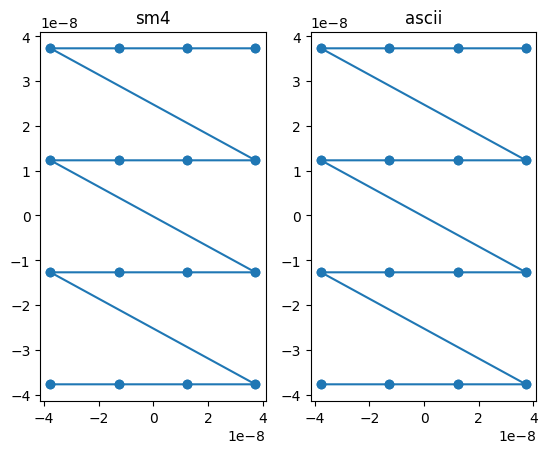

In [156]:
fig, (ax1, ax2) = pl.subplots(1, 2)

ax1.plot(
    d.spymdata.LIA_Current.attrs['RHK_SpecDrift_Xcoord'],
    d.spymdata.LIA_Current.attrs['RHK_SpecDrift_Ycoord'],
    'o-'
)
ax1.set_title('sm4')
ax2.plot(mapascii.coord[0, :], mapascii.coord[1, :], 'o-')
ax2.set_title('ascii')

reshape the X, Y coordinates of the spectra to fit the data shape

In [144]:
xcoo = pl.array(d.spymdata.LIA_Current.attrs['RHK_SpecDrift_Xcoord'])
ycoo = pl.array(d.spymdata.LIA_Current.attrs['RHK_SpecDrift_Ycoord'])
alternate = True
repetitions = 1
numberofspectra = (alternate + 1)*repetitions

In [145]:
tempx = pl.reshape(xcoo, (mapsize, mapsize, numberofspectra), order='C')
tempy = pl.reshape(ycoo, (mapsize, mapsize, numberofspectra), order='C')

In [146]:
tempx.shape

(4, 4, 2)

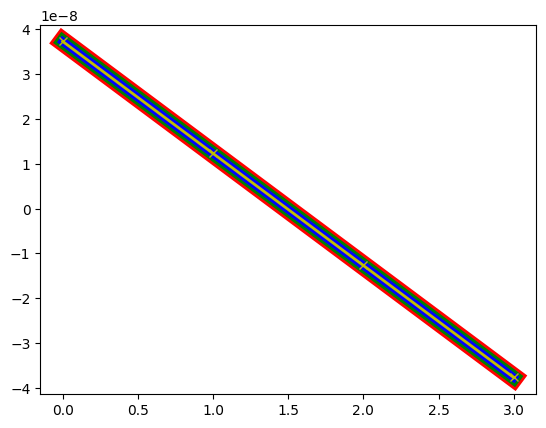

In [214]:
pl.plot(tempy[:, 0, 0], 'x-', color='r', lw = 14)
pl.plot(tempy[:, 1, 0], 'x-', color='g', lw = 10)
pl.plot(tempy[:, 2, 0], 'x-', color='b', lw = 6)
pl.plot(tempy[:, 3, 0], 'x-', color='y', lw = 2)

In [172]:
tempxcoo = tempx[0, :, 0]
tempycoo = tempy[:, 0, 0]

In [229]:
xrspec = xr.DataArray(pl.stack((d.lia_fw, d.lia_bw), axis=-1),
                          dims = ['bias', 'specpos_x', 'specpos_y', 'repetitions', 'scandir'],
                          coords = dict(
                               bias = d.spymdata.coords['LIA_Current_x'].data,
                               specpos_x = tempxcoo,
                               specpos_y = tempycoo,
                               repetitions = pl.array(range(repetitions)),
                               scandir = pl.array(['left', 'right'])
                          ),
                          attrs = dict(
                                   bias = d.spymdata.LIA_Current.attrs['bias']
                          )
                    )

select using `isel`

In [206]:
spec = xrspec.isel(specpos_x = 2, specpos_y = 1, repetitions = 0)
spec1 = xrspec.isel(specpos_x = 2, specpos_y = 1, repetitions = 0, scandir = 0)
spec2 = xrspec.isel(specpos_x = 2, specpos_y = 1, repetitions = 0, scandir = 1)

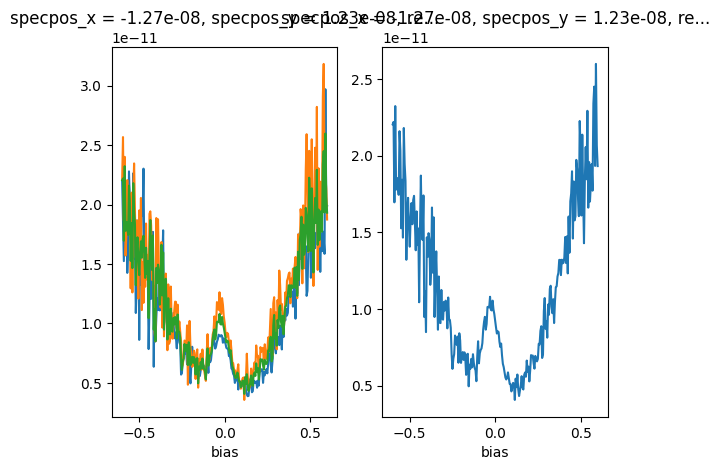

In [212]:
fig, (ax1, ax2) = pl.subplots(1, 2)

spec1.plot(ax=ax1)
spec2.plot(ax=ax1)
spec.mean(dim = "scandir").plot(ax=ax1)
spec.mean(dim = "scandir").plot(ax=ax2)

select using `sel`

In [220]:
spec_sel = xrspec.sel(specpos_x = 3*10**-8, specpos_y = 0, repetitions = 0, method='nearest')

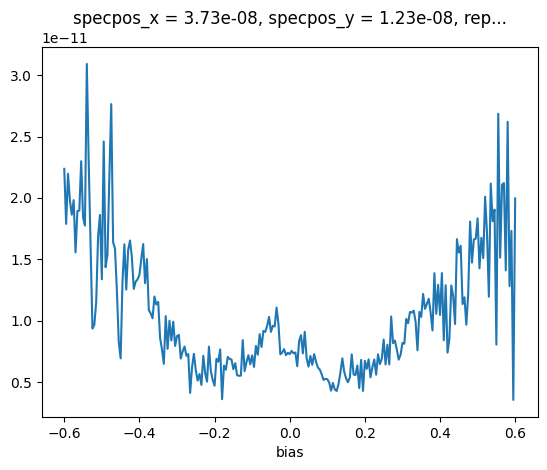

In [223]:
spec_sel.sel(scandir='left').plot()

In [344]:
xarrays = []
for key in d.__dict__:
    # print(isinstance(d.__dict__[key], str) or isinstance(d.__dict__[key], float) or isinstance(d.__dict__[key], int)
    if ((isinstance(d.__dict__[key], str) or isinstance(d.__dict__[key], float) or isinstance(d.__dict__[key], int)) is False) and key != 'spymdata':
        print(key)

lia
current


# Measurement types

In [4]:
d_topo_128 = spym.load('topo_ABC_Graphite-Sample5_9K_2021_08_13_19_11_10_065.sm4')

In [5]:
d_topo_256 = spym.load('topo_ABC_Graphite-Sample5_9K_2021_08_12_15_11_14_726.sm4')

In [204]:
filename_line = 'line_hopg_300k_2020_08_11_16_20_04_378.sm4'
d_linespec = spym.load(filename_line)

In [7]:
d_lia_image_128 = spym.load('lia_image_ABC_Graphite-Sample5_9K_2021_08_23_16_44_04_909.sm4')

In [8]:
d_lia_image_256 = spym.load('lia_image_ABC_Graphite-Sample5_9K_2021_08_17_23_02_19_872.sm4')

In [67]:
d_iz_spec = spym.load('Iz_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_15_28_529.sm4')

In [10]:
d_iz_line = spym.load('Iz_line_Stripes-9K-HOPG-SPI2-3_2021_09_02_15_15_35_930.sm4')

In [11]:
d_iz_map = spym.load('Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743.sm4')

In [12]:
d_spec = spym.load('dI-dV_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_23_58_152.sm4')

In [13]:
d_spec_incomplete = spym.load('dI-dV_incomplete_Stripes-9K-HOPG-SPI2-3_2021_09_06_16_15_26_118.sm4')

`ScanType` and `ScanTypeName` might be up / down scan

In [14]:
def printdatatype(s):
    l = list(s.keys())
    print(s[l[0]].attrs['filename'], '\n',
          'RHK_PageType \t', s[l[-1]].attrs['RHK_PageType'], '\n',
        'RHK_PageDataType \t', s[l[-1]].attrs['RHK_PageDataType'], '\n',
        'RHK_PageDataTypeName \t', s[l[-1]].attrs['RHK_PageDataTypeName'], '\n',
        'RHK_PageTypeName \t', s[l[-1]].attrs['RHK_PageTypeName'], '\n',
        'RHK_LineTypeName \t', s[l[-1]].attrs['RHK_LineTypeName'], '\n',
          'RHK_ImageType \t\t', s[l[-1]].attrs['RHK_ImageType'], '\n',
          'RHK_ImageTypeName \t', s[l[-1]].attrs['RHK_ImageTypeName'], '\n',
          'RHK_ScanType \t\t', s[l[-1]].attrs['RHK_ScanType'], '\n',
          'RHK_ScanTypeName \t', s[l[-1]].attrs['RHK_ScanTypeName']
    )

In [175]:
def printpage_linetype(s):
    l = list(s.keys())
    print(s[l[0]].attrs['filename'], '\n',
          'RHK_Signature \t', s[l[-1]].attrs['RHK_Signature'], '\n',
          'RHK_MinorVer \t', s[l[-1]].attrs['RHK_MinorVer'], '\n',
          'RHK_PageType \t', s[l[-1]].attrs['RHK_PageType'], '\n',
          'RHK_LineType \t', s[l[-1]].attrs['RHK_LineType']
    )

In [16]:
printdatatype(d_iz_spec)

Iz_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_15_28_529.sm4 
 RHK_PageType 	 38 
 RHK_PageDataType 	 1 
 RHK_PageDataTypeName 	 RHK_DATA_LINE 
 RHK_PageTypeName 	 RHK_PAGE_RAMP_SPECTROSCOPY_RP 
 RHK_LineTypeName 	 RHK_LINE_IZ_SPECTRUM 
 RHK_ImageType 		 0 
 RHK_ImageTypeName 	 RHK_IMAGE_NORMAL 
 RHK_ScanType 		 1 
 RHK_ScanTypeName 	 RHK_SCAN_LEFT


In [176]:
printpage_linetype(d_linespec)

line_hopg_300k_2020_08_11_16_20_04_378.sm4 
 RHK_Signature 	 STiMage 005.004 1 
 RHK_MinorVer 	 6 
 RHK_PageType 	 16 
 RHK_LineType 	 7


# Testing $dI/dV$ map on a larger map

In [338]:
abc_aba_map = sm4.stmdata('ABC_Graphite-Sample5_9K_2021_08_23_02_27_55_533.sm4')

map
iv


In [341]:
fwmap = abc_aba_map.specmap.isel(biasscandir = 0, repetitions = 0)

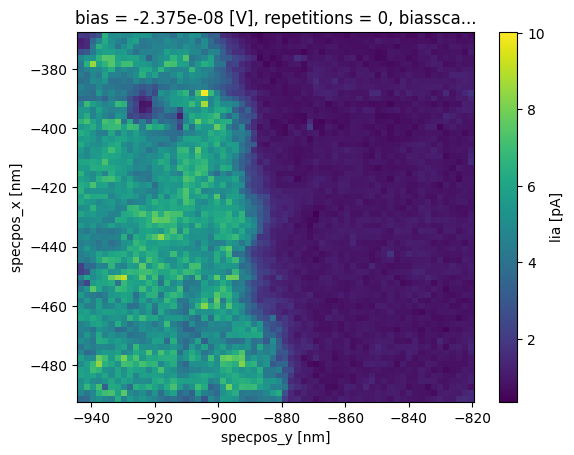

In [346]:
fwmap['lia'].sel(bias = 0, method = 'nearest').plot()